# Inverse Compton Scattering

At the low energy limit, Tracy calculated an approximate expression for dN/(dt deps1), which is the number of photons per scattered energy eps1 per unit time. This expression is presented as an integrand, integrated over the CMB spectrum.

In [1]:
%load_ext autoreload

In [25]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle

from scipy import integrate

import darkhistory.physics as phys
import darkhistory.electrons.ics.ics_loweng as ics_loweng

In [30]:
transfer_func_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw","rb"))
testphoteng_arr = transfer_func_table.in_eng

In [36]:
testeleceng_arr = np.array([2e7,4e8, 3e9])
a = ics_loweng.icsspec_loweng(testeleceng_arr, testphoteng_arr, 10000)

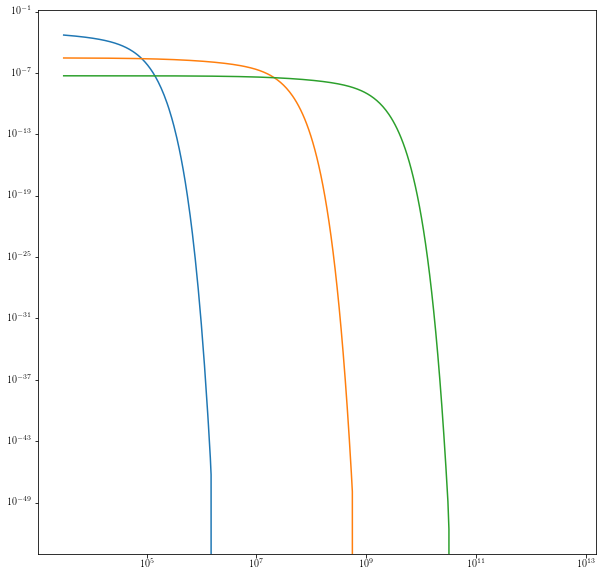

In [37]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
a.plot(ax, ind=np.array([0,1,2]), indtype='ind')

ax.set_xscale('log')
ax.set_yscale('log')

In [38]:
a.dlnz

2.3027919972662845e-12